# Non-Linear SVM Classification: 
One approach to handling nonlinear datasets is to add more features, such as polynomial
features (as we did in Chapter 4); in some cases this can result in a linearly separable dataset. 

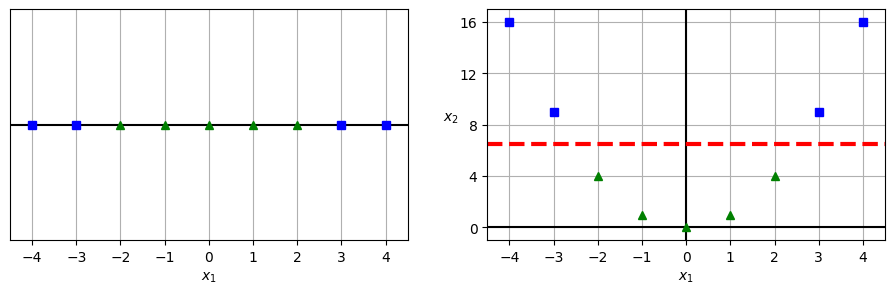

In [1]:
# extra code – this cell generates and saves Figure 5–5
import numpy as np
import matplotlib.pyplot as plt


X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

In [2]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X,y = make_moons(n_samples=100,noise=0.15,random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10,max_iter=10_000,random_state=42)
)
polynomial_svm_clf.fit(X,y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

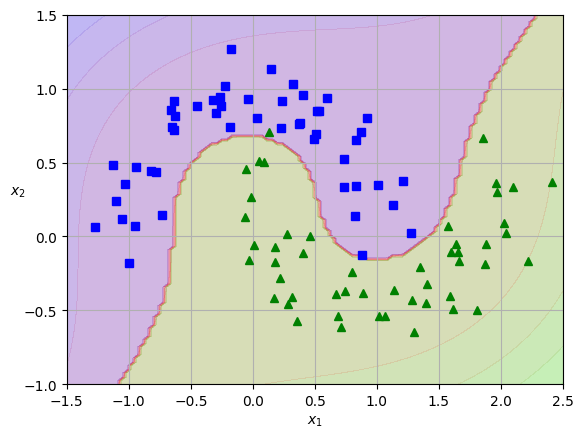

In [4]:
# extra code – this cell generates and saves Figure 5–6

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

# Polynomail Kernel:
1) at a low polynomial degree this method cannot deal with very complex
datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow

2) when using SVMs you can apply an almost miraculous mathematical technique called the kernel trick.  The kernel trick makes it possible to get the same result as if you had
added many polynomial features, even with a very high degree, without actually having to add them. This means
there’s no combinatorial explosion of the number of features

In [8]:
from sklearn.svm import SVC
poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly",degree=3,coef0=1,C=5))
poly_kernel_svm_clf.fit(X,y)

# The hyperparameter coef0 controls how much the model is influenced by high-degree terms versus
# low-degree terms.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

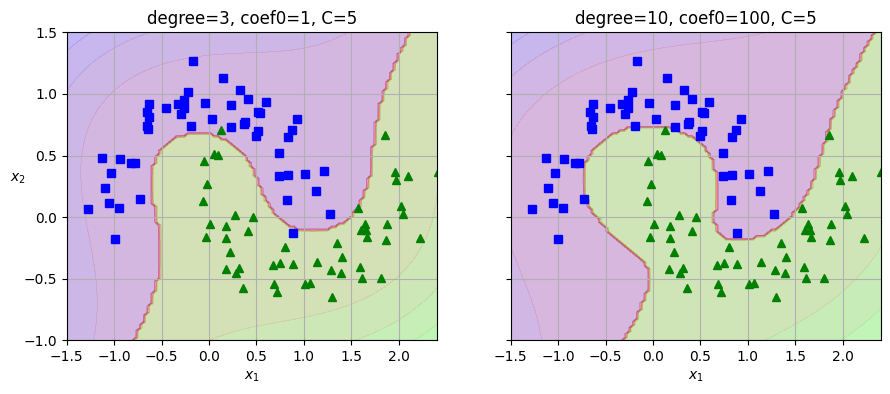

In [9]:
# extra code – this cell generates and saves Figure 5–7
from sklearn.svm import SVC

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

plt.show()


> TIP: 
Although hyperparameters will generally be tuned automatically (e.g., using randomized search), it’s good to have a sense of what each
hyperparameter actually does and how it may interact with other hyperparameters: this way, you can narrow the search to a much smaller
space.

# Similarity Features:
1) Another technique to tackle nonlinear problems is to add features computed using a similarity function, which
measures how much each instance resembles a particular landmark.

2) let’s take the 1D dataset from earlier and add two landmarks to it at x
= –2 and x = 1 (see the left plot in Figure 5-8). Next, we’ll define the similarity function to be the Gaussian RBF
with γ = 0.3. This is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the
landmark).

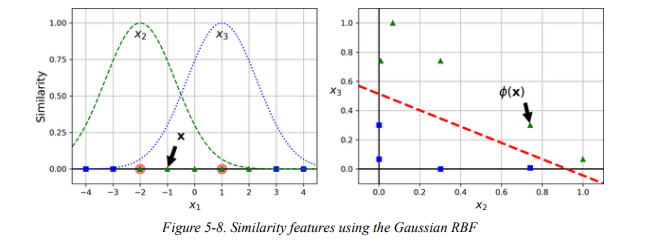

3) You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of
each and every instance in the dataset. Doing that creates many dimensions and thus increases the chances that the
transformed training set will be linearly separable. The downside is that a training set with m instances and n
features gets transformed into a training set with m instances and m features (assuming you drop the original
features). If your training set is very large, you end up with an equally large number of features.

4) Gaussian RBF kernel:
it may be computationally expensive to compute all the additional features (especially on large
training sets). Once again the kernel trick does its SVM magic, making it possible to obtain a similar result as if
you had added many similarity features, but without actually doing so.

5) This model is represented at the bottom left in Figure 5-9. The other plots show models trained with different
values of hyperparameters gamma (γ) and C. Increasing gamma makes the bell-shaped curve narrower (see the
lefthand plots in Figure 5-8). As a result, each instance’s range of influence is smaller: the decision boundary ends
up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bellshaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother. So γ
acts like a regularization hyperparameter: if your model is overfitting, you should reduce γ; if it is underfitting, you
should increase γ (similar to the C hyperparameter).


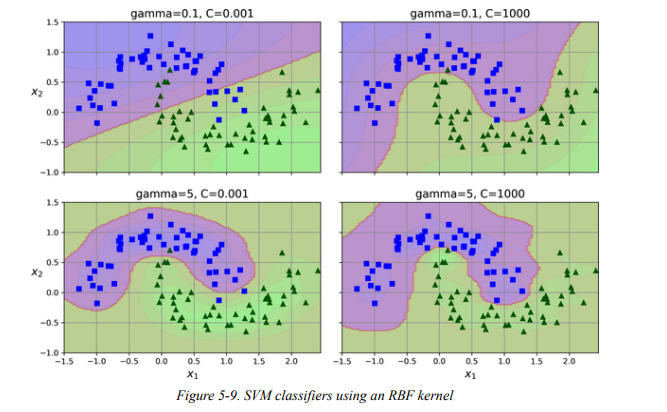

Other kernels exist but are used much more rarely. Some kernels are specialized for specific data structures. String
kernels are sometimes used when classifying text documents or DNA sequences (e.g., using the string subsequence
kernel or kernels based on the Levenshtein distance).



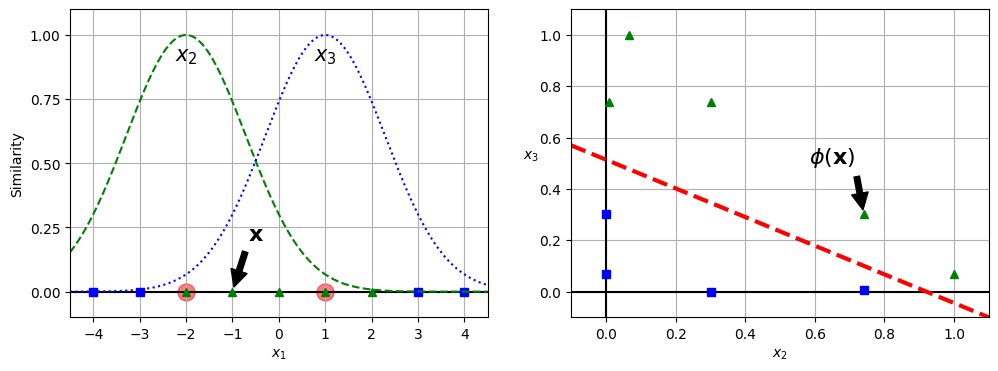

In [10]:
# extra code – this cell generates and saves Figure 5–8

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r'$\mathbf{x}$',
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$  ", rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()

In [11]:
rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf',gamma=5,C=0.001)
)
rbf_kernel_svm_clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

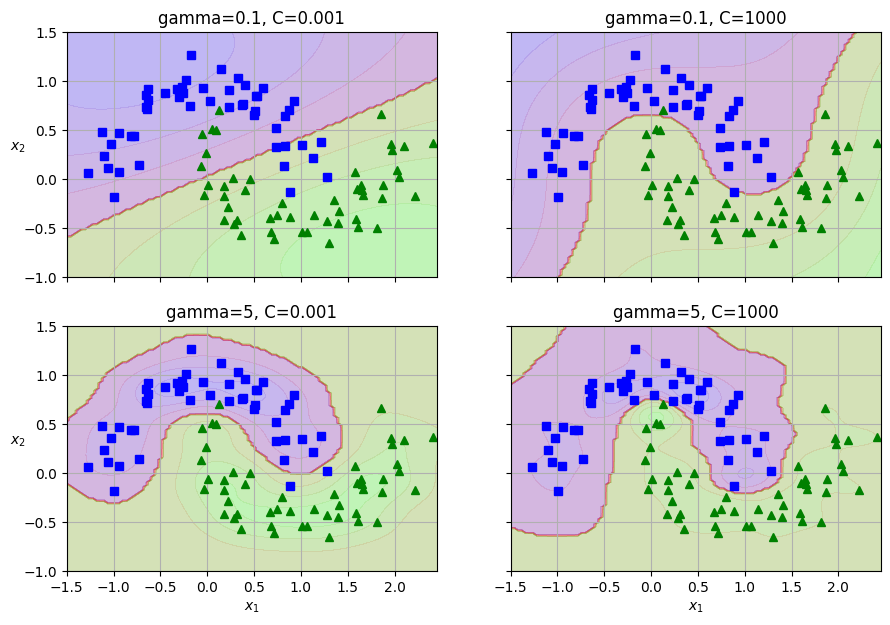

In [12]:
# extra code – this cell generates and saves Figure 5–9

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

>TIP:
With so many kernels to choose from, how can you decide which one to use? As a rule of thumb, you should always try the linear kernel
first. The LinearSVC class is much faster than SVC(kernel="linear"), especially if the training set is very large. If it is not too large, you
should also try kernelized SVMs, starting with the Gaussian RBF kernel; it often works really well. Then, if you have spare time and
computing power, you can experiment with a few other kernels using hyperparameter search. If there are kernels specialized for your
training set’s data structure, make sure to give them a try too.


# SVM Classes and Computational Complexity:

1) LinearSVC : implements an optimized algorithm for linear
SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and
the number of features. Its training time complexity is roughly O(m × n). The algorithm takes longer if you require
very high precision. This is controlled by the tolerance hyperparameter ϵ (called tol in Scikit-Learn) (default tol is fine in most classification tasks).

2) SVC :  implements an algorithm that supports the kernel trick. The
training time complexity is usually between O(m^2 × n) and O(m^3 × n).  this
algorithm is best for small or medium-sized nonlinear training sets. It scales well with the number of features,
especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm
scales roughly with the average number of nonzero features per instance.

3) SGDClassifier: also performs large margin classification by default, and its hyperparameters–especially
the regularization hyperparameters (alpha and penalty) and the learning_rate–can be adjusted to produce
similar results as the linear SVMs. It allows
incremental learning and uses little memory, so you can use it to train a model on a large dataset that does not fit in
RAM (i.e., for out-of-core learning). Moreover, it scales very well, as its computational complexity is O(m × n)